# Part 1: Exploratory Data Analysis & Data Preparation

This notebook serves as the foundation for the Instacart Reorder Prediction Project. It focuses on understanding the structure, quality, and patterns in the raw dataset, and preparing a clean, enriched dataset for modeling and analysis.

  
# Files Used

- `orders.csv`: Contains metadata about each order, including user ID, order sequence, and time of placement.
- `order_products__prior.csv`: Historical product-level purchases for all previous orders.
- `order_products__train.csv`: Products from the final training orders, used for supervised model training.
- `products.csv`: Product names with references to aisle and department.
- `aisles.csv`: Aisle categories.
- `departments.csv`: Department categories.

# Data Merging Workflow

1. Filtered the `orders` file to retain only `prior` orders.
2. Merged with `order_products__prior` to get detailed product purchase info.
3. Added product metadata from `products.csv`.
4. Joined with aisle and department metadata.
5. Resulted in a rich `prior_data` table with 32M+ rows and 15 fields covering user, product, time, and category dimensions.


## Key Exploratory Insights

### 1. Basket Size per Order
Most baskets contain fewer than **15 products**, indicating customers often shop for a small set of items per order. Order frequency sharply declining as basket size increases.

### 2. Order Trends by Day of Week
Majority of orders occur on **Sundays and Mondays**, likely due to weekly planning habits. The lowest activity observed during midweek on Wednesdays and Thursdays.

### 3. Orders by Hour of Day
Peak order activity is between **9 AM and 4 PM**, likely reflecting active user hours. Minimal activity observed during late-night and early-morning hours.

### 4. Reorder Ratio
- **Global Reorder Ratio**: `0.59`
- **Top Reordered Products**:
products like Raw Veggie Wrappers and Serenity Ultimate Extrema Overnight Pads lead reordering behavior, each exceeding a 93% reorder rate

Raw Veggie Wrappers                         0.941176
Serenity Ultimate Extrema Overnight Pads    0.931034
Orange Energy Shots                         0.923077
Chocolate Love Bar                          0.920792
Soy Powder Infant Formula                   0.914286
Simply Sleep Nighttime Sleep Aid            0.911111
Energy Shot, Grape Flavor                   0.909091
Sparking Water                              0.900000
Russian River Valley Reserve Pinot Noir     0.900000
Maca Buttercups                             0.900000

### 5. Most Purchased Departments
Top categories include:
- Produce
- Dairy & Eggs
- Snacks
- Beverages

### 6. Days Since Prior Order
- Peak reorder interval: **6–7 days**, highlighting weekly cycles
- Long tail at 30 days may reflect monthly shoppers

## Outcome

- Cleaned and merged a 32M+ row dataset across 6 sources
- Gained insights into ordering behaviors, timing, and product categories
- Saved as `prior_data` for feature engineering and modeling

## Next Steps

Move into feature engineering to build behavioral, product, and interaction-level metrics for reorder prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy.stats import entropy
import sys

In [2]:
# Load files
orders = pd.read_csv("orders.csv")
order_products_prior = pd.read_csv("order_products__prior.csv")
order_products_train = pd.read_csv("order_products__train.csv")
products = pd.read_csv("products.csv")
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")

In [3]:
orders.to_pickle('orders.pkl')
order_products_prior.to_pickle('order_products_prior .pkl')
order_products_train.to_pickle('order_products_train.pkl')
products.to_pickle('products.pkl')
aisles.to_pickle('aisles.pkl')
departments.to_pickle('departments.pkl')

In [4]:
print("orders:", orders.shape)
print("order_products_prior:",order_products_prior.shape)
print("order_products_train:", order_products_train.shape)
print("products:", products.shape)
print("aisles:", aisles.shape)
print("departments:", departments.shape)

orders: (3421083, 7)
order_products_prior: (32434489, 4)
order_products_train: (1384617, 4)
products: (49688, 4)
aisles: (134, 2)
departments: (21, 2)


In [5]:
from IPython.display import display

print("orders")
display(orders.head())

print("order_products_prior")
display(order_products_prior.head())

print("order_products_train")
display(order_products_train.head())

print("products")
display(products.head())

print("aisles")
display(aisles.head())

print("departments")
display(departments.head())

orders


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


order_products_prior


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


order_products_train


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


products


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


aisles


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


departments


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [6]:
# Step 1: Filter orders to only prior orders
prior_orders = orders[orders['eval_set'] == 'prior']

# Step 2: Merge prior orders with order_products__prior on order_id
prior_data = prior_orders.merge(order_products_prior, on='order_id', how='inner')

# Step 3: Merge with products to get product info
prior_data = prior_data.merge(products, on='product_id', how='left')

# Step 4: Merge with aisles to get aisle names
prior_data = prior_data.merge(aisles, on='aisle_id', how='left')

# Step 5: Merge with departments to get department names
prior_data = prior_data.merge(departments, on='department_id', how='left')

# Now we have a rich dataset with user, order, product, aisle, and department info
print("Final prior_data shape:", prior_data.shape)
display(prior_data.head())


Final prior_data shape: (32434489, 15)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks,beverages
1,2539329,1,prior,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,soy lactosefree,dairy eggs
2,2539329,1,prior,1,2,8,NaN,12427,3,0,Original Beef Jerky,23,19,popcorn jerky,snacks
3,2539329,1,prior,1,2,8,NaN,26088,4,0,Aged White Cheddar Popcorn,23,19,popcorn jerky,snacks
4,2539329,1,prior,1,2,8,NaN,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,paper goods,household


In [7]:
prior_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
 7   product_id              int64  
 8   add_to_cart_order       int64  
 9   reordered               int64  
 10  product_name            object 
 11  aisle_id                int64  
 12  department_id           int64  
 13  aisle                   object 
 14  department              object 
dtypes: float64(1), int64(10), object(4)
memory usage: 3.6+ GB


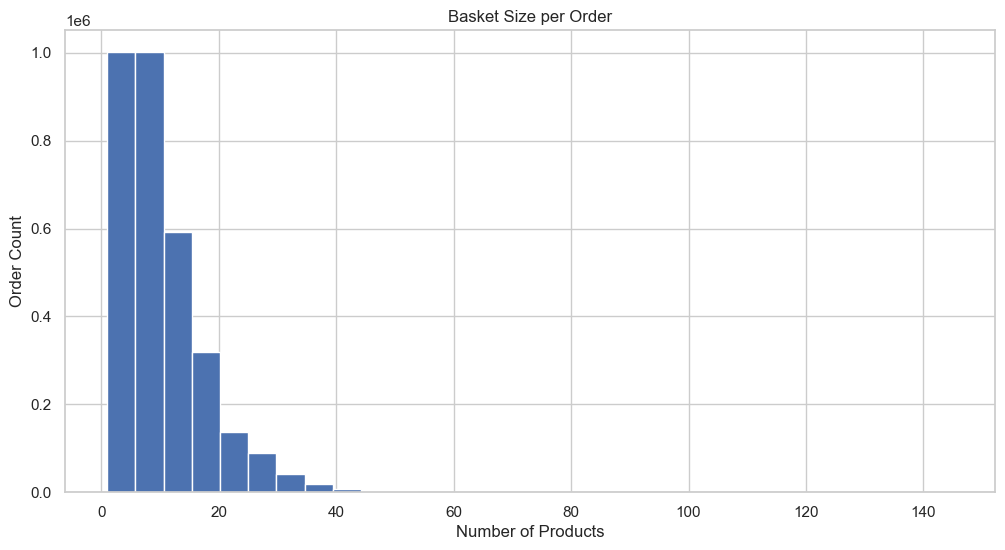

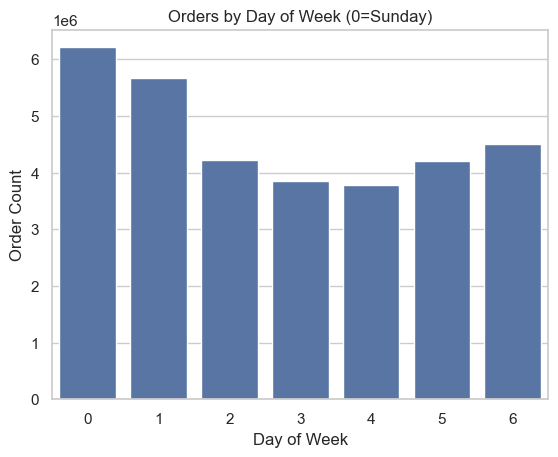

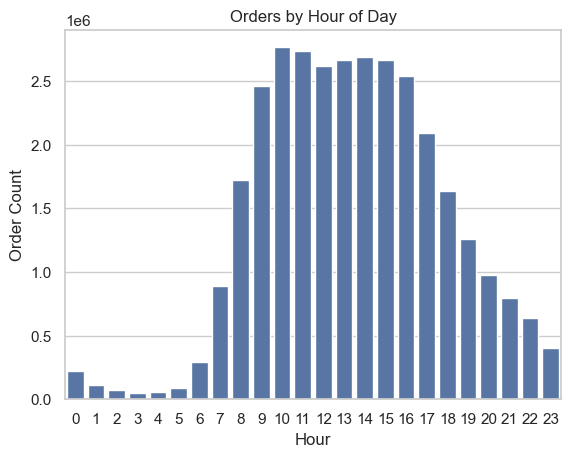

Global Reorder Ratio: 0.59
Top 10 Most Reordered Products:
product_name
Raw Veggie Wrappers                         0.941176
Serenity Ultimate Extrema Overnight Pads    0.931034
Orange Energy Shots                         0.923077
Chocolate Love Bar                          0.920792
Soy Powder Infant Formula                   0.914286
Simply Sleep Nighttime Sleep Aid            0.911111
Energy Shot, Grape Flavor                   0.909091
Sparking Water                              0.900000
Russian River Valley Reserve Pinot Noir     0.900000
Maca Buttercups                             0.900000
Name: reordered, dtype: float64


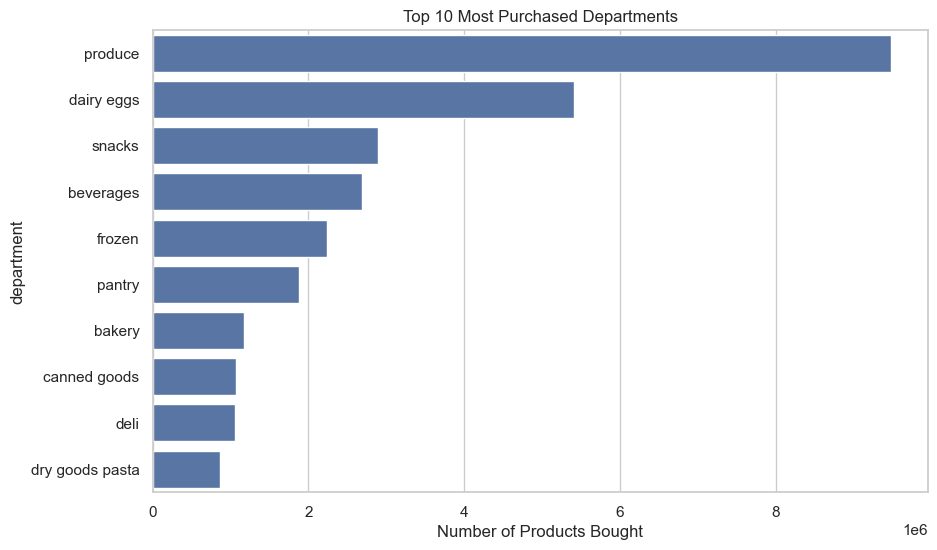

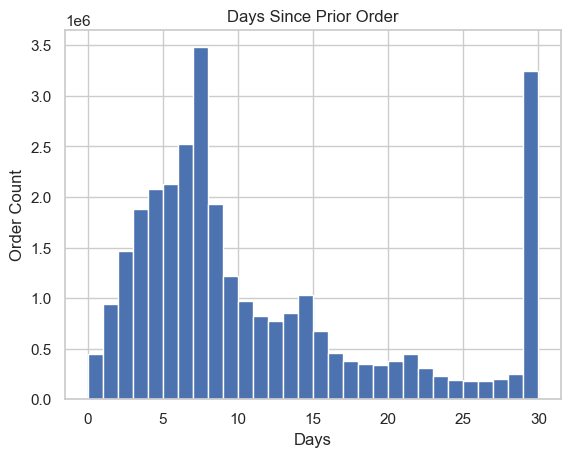

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# 1. Basket Size per Order
prior_data.groupby('order_id')['product_id'].count().plot.hist(bins=30)
plt.title("Basket Size per Order")
plt.xlabel("Number of Products")
plt.ylabel("Order Count")
plt.show()

# 2. Orders by Day of Week
sns.countplot(x='order_dow', data=prior_data)
plt.title("Orders by Day of Week (0=Sunday)")
plt.xlabel("Day of Week")
plt.ylabel("Order Count")
plt.show()

# 3. Orders by Hour of Day
sns.countplot(x='order_hour_of_day', data=prior_data)
plt.title("Orders by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Order Count")
plt.show()

# 4. Reorder Ratio (Global)
reorder_ratio = prior_data['reordered'].mean()
print(f"Global Reorder Ratio: {reorder_ratio:.2f}")

# 5. Top 10 Most Reordered Products
top_reorder_products = (prior_data.groupby('product_name')['reordered']
                        .mean()
                        .sort_values(ascending=False)
                        .head(10))
print("Top 10 Most Reordered Products:")
print(top_reorder_products)

# 6. Popular Departments
dept_counts = (prior_data.groupby('department')['product_id']
               .count()
               .sort_values(ascending=False)
               .head(10))
plt.figure(figsize=(10, 6))
sns.barplot(x=dept_counts.values, y=dept_counts.index)
plt.title("Top 10 Most Purchased Departments")
plt.xlabel("Number of Products Bought")
plt.show()

# 7. Days Since Prior Order (Recency Insight)
prior_data['days_since_prior_order'].dropna().plot.hist(bins=30)
plt.title("Days Since Prior Order")
plt.xlabel("Days")
plt.ylabel("Order Count")
plt.show()

## Key Exploratory Insights

### 1. Basket Size per Order
Most baskets contain fewer than **15 products**, indicating customers often shop for a small set of items per order. Order frequency sharply declining as basket size increases.

### 2. Order Trends by Day of Week
Majority of orders occur on **Sundays and Mondays**, likely due to weekly planning habits. The lowest activity observed during midweek on Wednesdays and Thursdays.

### 3. Orders by Hour of Day
Peak order activity is between **9 AM and 4 PM**, likely reflecting active user hours. Minimal activity observed during late-night and early-morning hours.

### 4. Reorder Ratio
- **Global Reorder Ratio**: `0.59`
- **Top Reordered Products**:
products like Raw Veggie Wrappers and Serenity Ultimate Extrema Overnight Pads lead reordering behavior, each exceeding a 93% reorder rate

Raw Veggie Wrappers                         0.941176
Serenity Ultimate Extrema Overnight Pads    0.931034
Orange Energy Shots                         0.923077
Chocolate Love Bar                          0.920792
Soy Powder Infant Formula                   0.914286
Simply Sleep Nighttime Sleep Aid            0.911111
Energy Shot, Grape Flavor                   0.909091
Sparking Water                              0.900000
Russian River Valley Reserve Pinot Noir     0.900000
Maca Buttercups                             0.900000

### 5. Most Purchased Departments
Top categories include:
- Produce
- Dairy & Eggs
- Snacks
- Beverages

### 6. Days Since Prior Order
- Peak reorder interval: **6–7 days**, highlighting weekly cycles
- Long tail at 30 days may reflect monthly shoppers


In [9]:
prior_data.to_pickle('prior_data.pkl')